In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from datetime import datetime

class Simulador:
    def __init__(self, params=None) -> None:
        print('===============     Simulador.__init__()     =================')
        self.params = params
        self.preditores_treino, self.preditores_teste, self.alvo_treino, self.alvo_teste = (None, None, None, None)
        self.sigla_ativo = params['sigla_ativo'] if 'sigla_ativo' in params else 'BTC-USD' #sigla_ativo
        self.data_inicial = params['data_inicial'] if 'data_inicial' in params else '2023-01-01' #data_inicial
        self.data_final = params['data_final'] if 'data_final' in params else '2024-11-01' #data_final
        self.modelo = params['modelo'] if 'modelo' in params else DecisionTreeClassifier(random_state=42)
        self.DEBUG = params['DEBUG'] if 'DEBUG' in params else False
        self.janela_treino = params['janela_treino'] if 'janela_treino' in params else 365
        self.preditores = params['preditores'] if 'preditores' in params else [
            'rsi_14', 'mm_exp_21', 'razao_amplitude', 'max_div_min', 'ret_dia_anterior'
        ]
        self.proporcao_teste = params['proporcao_teste'] if 'proporcao_teste' in params else 0.25
        self.stop_loss = params['stop_loss'] if 'stop_loss' in params else {'tipo': 'fixo', 'valor': 0.05}
        self.intervalo = params['intervalo'] if 'intervalo' in params else '1d'
        self.df = None
    
    def getPrecos(self) -> None:
        print('===============     Simulador.getPrecos()     =================')
        self.df = yf.download(self.sigla_ativo, start=self.data_inicial, end=self.data_final, interval=self.intervalo)
        self.df['data'] = self.df.index
        self.df = self.df.copy()  # Garante que self.df é uma cópia independente
        print('data inicial:', self.df.index[0], 'data final:', self.df.index[-1], 'linhas na base:', len(self.df))
    
    def addIndicadores(self) -> None:
        print('===============     Simulador.addIndicadores()     =================')
        self.df['rsi_7'] = RSIIndicator(self.df['Close'], window=7).rsi()
        self.df['rsi_30'] = RSIIndicator(self.df['Close'], window=30).rsi()
        self.df['mm_exp_7'] = EMAIndicator(self.df['Close'], window=7).ema_indicator() / self.df['Close']
        self.df['mm_exp_30'] = EMAIndicator(self.df['Close'], window=30).ema_indicator() / self.df['Close']

        self.df['razao_mm_exp_7_30'] = self.df['mm_exp_7'] / self.df['mm_exp_30']

        self.df['razao_amplitude'] = (self.df['Close'] - self.df['Low']) / (self.df['High'] - self.df['Low'])
        self.df['max_div_min'] = (self.df['High'] / self.df['Low']) - 1
        self.df['ret_dia_anterior'] = self.df['Close'].pct_change()
        self.df['tendencia'] = list(range(len(self.df)))

        # self.df['open_0'] = np.log(self.df['Open'])
        # self.df['open_1'] = np.log(self.df['open_0'].shift(1))
        # self.df['open_2'] = np.log(self.df['open_0'].shift(2))
        # self.df['open_3'] = np.log(self.df['open_0'].shift(3))
        # self.df['open_4'] = np.log(self.df['open_0'].shift(4))
        # self.df['open_5'] = np.log(self.df['open_0'].shift(5))
        # self.df['high_0'] = np.log(self.df['High'])
        # self.df['high_1'] = np.log(self.df['high_0'].shift(1))
        # self.df['high_2'] = np.log(self.df['high_0'].shift(2))
        # self.df['high_3'] = np.log(self.df['high_0'].shift(3))
        # self.df['high_4'] = np.log(self.df['high_0'].shift(4))
        # self.df['high_5'] = np.log(self.df['high_0'].shift(5))
        # self.df['low_0'] = np.log(self.df['Low'])
        # self.df['low_1'] = np.log(self.df['low_0'].shift(1))
        # self.df['low_2'] = np.log(self.df['low_0'].shift(2))
        # self.df['low_3'] = np.log(self.df['low_0'].shift(3))
        # self.df['low_4'] = np.log(self.df['low_0'].shift(4))
        # self.df['low_5'] = np.log(self.df['low_0'].shift(5))
        # self.df['close_0'] = np.log(self.df['Close'])
        # self.df['close_1'] = np.log(self.df['close_0'].shift(1))
        # self.df['close_2'] = np.log(self.df['close_0'].shift(2))
        # self.df['close_3'] = np.log(self.df['close_0'].shift(3))
        # self.df['close_4'] = np.log(self.df['close_0'].shift(4))
        # self.df['close_5'] = np.log(self.df['close_0'].shift(5))

        # # Selecionar apenas as colunas que deseja normalizar
        # cols_to_normalize = [
        #     'open_0', 'open_1', 'open_2', 'open_3', 'open_4', 'open_5',
        #     'high_0', 'high_1', 'high_2', 'high_3', 'high_4', 'high_5',
        #     'low_0', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5',
        #     'close_0', 'close_1', 'close_2', 'close_3', 'close_4', 'close_5'
        # ]

        # # Normalizar cada linha para que seus valores fiquem entre 0 e 1
        # self.df[cols_to_normalize] = self.df[cols_to_normalize].apply(
        #     lambda row: (row - row.min()) / (row.max() - row.min()) if row.max() != row.min() else np.zeros(len(row)),
        #     axis=1
        # )

        print('ANTES:',len(self.df), 'linhas na base:', 'de', self.df.index[0], 'até', self.df.index[-1])
        self.df = self.df.copy().dropna()
        print('DEPOIS:',len(self.df), 'linhas na base:', 'de', self.df.index[0], 'até', self.df.index[-1])
        print('===========================================================')
        print(self.df.head(1).T)
    
    def addAlvo(self) -> None:
        print('===============     Simulador.addAlvo()     =================')
        self.df['alvo'] = (self.df['Close'].shift(-1) > self.df['Close']).astype(int)
        # print('ANTES:',len(self.df), 'linhas na base:', 'de', self.df.index[0], 'até', self.df.index[-1])
        # self.df = self.df.copy().dropna()
        # print('DEPOIS:',len(self.df), 'linhas na base:', 'de', self.df.index[0], 'até', self.df.index[-1])
        # print('===========================================================')

    def runDivisaoTreinoTeste(self) -> tuple:
        print('===============     Simulador.runDivisaoTreinoTeste()     =================')
        X = self.df[self.preditores]
        y = self.df['alvo']
        return train_test_split(X, y, test_size=self.proporcao_teste, random_state=42, shuffle=False)
    
    def runTreinarModelo(self, modelo, X_train, y_train) -> None:
        modelo.fit(X_train, y_train)
    
    def addSinal(self, X_train, X_test, so_compra=False) -> None:
        print('===============     Simulador.addSinal()     =================')
        self.df.loc[:, 'sinal'] = pd.Series(np.nan, index=self.df.index)
        self.df.loc[X_train.index, 'Close'] = pd.Series(np.nan, index=X_train.index)
        if self.params['so_compra']==True:
            self.df.loc[X_test.index, 'sinal'] = self.modelo.predict(X_test)
        else:
            self.df.loc[X_test.index, 'sinal'] = self.modelo.predict(X_test)
            self.df.loc[X_test.index, 'sinal'] = self.df.loc[X_test.index, 'sinal'].map({1: 1, 0: -1})
    
    def addRetornos(self) -> None:
        print('===============     Simulador.addRetornos()     =================')
        self.df.loc[self.df['sinal'].notna(),'retornos_estrategia'] = \
            self.df.loc[self.df['sinal'].notna(),'sinal'].shift(1) * self.df.loc[self.df['sinal'].notna(),'Close'].pct_change()
        self.df['retornos_acumulados_estrategia'] = (1 + self.df['retornos_estrategia']).cumprod() - 1

        self.df.loc[self.df['sinal'].notna(),'retornos_compra_e_segura'] = \
            self.df.loc[self.df['sinal'].notna(),'Close'].pct_change()
        self.df['retornos_acumulados_compra_e_segura'] = (1 + self.df['retornos_compra_e_segura']).cumprod() - 1

        if params['stop_loss']['tipo'] == 'fixo':
            self.df.loc[self.df['sinal'].notna(), 'retornos_compra_e_segura_stop'] = \
                np.where(self.df.loc[self.df['sinal'].notna(), 'variacao_close_min'] < -params['stop_loss']['valor'],
                        -params['stop_loss']['valor'],
                        self.df.loc[self.df['sinal'].notna(), 'retornos_compra_e_segura'])
            self.df['retornos_acumulados_compra_e_segura_stop'] = (1 + self.df['retornos_compra_e_segura_stop']).cumprod() - 1

            self.df.loc[self.df['sinal'].notna(), 'retornos_estrategia_stop'] = \
                np.where(self.df.loc[self.df['sinal'].notna(), 'variacao_close_min'] < -params['stop_loss']['valor'],
                        -params['stop_loss']['valor'],
                        self.df.loc[self.df['sinal'].notna(), 'retornos_estrategia'])
            self.df['retornos_acumulados_estrategia_stop'] = (1 + self.df['retornos_estrategia_stop']).cumprod() - 1

        elif params['stop_loss']['tipo'] == 'dinamico':
            self.df.loc[self.df['sinal'].notna(), 'retornos_compra_e_segura_stop'] = \
                np.where(self.df.loc[self.df['sinal'].notna(), 'variacao_close_min'] < self.df.loc[self.df['sinal'].notna(), 'variacao_close_min'].shift(1) - params['stop_loss']['valor'],
                        self.df.loc[self.df['sinal'].notna(), 'variacao_close_min'].shift(1),
                        self.df.loc[self.df['sinal'].notna(), 'retornos_compra_e_segura'])
            self.df['retornos_acumulados_compra_e_segura_stop'] = (1 + self.df['retornos_compra_e_segura_stop']).cumprod() - 1

            self.df.loc[self.df['sinal'].notna(), 'retornos_estrategia_stop'] = \
                np.where(self.df.loc[self.df['sinal'].notna(), 'variacao_close_min'] < self.df.loc[self.df['sinal'].notna(), 'variacao_close_min'].shift(1) - params['stop_loss']['valor'],
                        self.df.loc[self.df['sinal'].notna(), 'variacao_close_min'].shift(1),
                        self.df.loc[self.df['sinal'].notna(), 'retornos_estrategia'])
            self.df['retornos_acumulados_estrategia_stop'] = (1 + self.df['retornos_estrategia_stop']).cumprod() - 1
    
    def runGraficos(self) -> None:
        print('===============     Simulador.runGraficos()     =================')
        self.df.set_index('data', inplace=True)
        plt.figure(figsize=(12, 6))
        plt.plot(self.df['retornos_acumulados_estrategia'], label='Estratégia', linestyle='--')
        plt.plot(self.df['retornos_acumulados_compra_e_segura'], label='Buy & Hold', linestyle=':')
        if params['stop_loss']['tipo'] == 'fixo':
            plt.plot(self.df['retornos_acumulados_estrategia_stop'], label=f'Estratégia com Stop Loss de {params["stop_loss"]["valor"]}', linestyle='-.')
            plt.plot(self.df['retornos_acumulados_compra_e_segura_stop'], label=f'Buy & Hold com Stop Loss de {params["stop_loss"]["valor"]}', linestyle='-')
        elif params['stop_loss']['tipo'] == 'dinamico':
            plt.plot(self.df['retornos_acumulados_estrategia_stop'], label=f'Estratégia com Stop Loss dinâmico de {params["stop_loss"]["valor"]}', linestyle='-.')
            plt.plot(self.df['retornos_acumulados_compra_e_segura_stop'], label=f'Buy & Hold com Stop Loss dinâmico de {params["stop_loss"]["valor"]}', linestyle='-')
        plt.title('Comparação de Retornos Acumulados')
        plt.xlabel('Data')
        plt.ylabel('Retorno Acumulado')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def getAcuracia(self, previsto, real) -> float:
        print('===============     Simulador.getAcuracia()     =================')
        accuracy = accuracy_score(previsto, real)
        print(f"Acurácia no conjunto de teste: {accuracy:.2%}")
        return accuracy
    
    def getRecomendacoes(self) -> None:
        print('===============     Simulador.getRecomendacoes()     =================')
        print('Recomendações:')
        if self.df[['sinal']].values[-1][0] == 1:
            print(self.df['data'].values[-1],'COMPRAR', self.sigla_ativo, 'no preço', self.df['Close'].values[-1])
        else:
            print(self.df['data'].values[-1],'VENDER', self.sigla_ativo, 'no preço', self.df['Close'].values[-1])
    
    def addVariacaoCloseMin(self) -> None:
        print('===============     Simulador.addVariacaoCloseMin()     =================')
        self.df['variacao_close_min'] = self.df['Low']/self.df['Close'].shift(1) - 1

    def runSimulacaoInterativa(self) -> None:
        print('===============     Simulador.runSimulacaoInterativa()     =================')
        """
        Executa o forward backtesting: treina o modelo em cada dia e testa no próximo dia.
        """
        self.getPrecos()
        self.addIndicadores()
        self.addAlvo()
        resultados = []
        for i in range(len(self.df) - self.janela_treino):
            modelo = self.modelo # Cria uma cópia do modelo para cada iteração
            treino = self.df.iloc[i:(i + self.janela_treino)]
            teste = self.df.iloc[(i + self.janela_treino):(i + self.janela_treino + 1)]
            print('Testando o modelo em:', teste.index[0], 'interação', i, 'linha', i + self.janela_treino)
            
            X_train = treino[self.preditores]
            y_train = treino['alvo']
            
            X_test = teste[self.preditores]
            y_test = teste['alvo']
            
            if X_test.isnull().values.any():
                print(f"Valores ausentes encontrados em X_test na data {teste.index[0]}. Pulando previsão.")
                continue  # Ignora iteração se houver NaN

            # Treinando o modelo com os dados de treino até o dia atual
            self.runTreinarModelo(modelo, X_train, y_train)

            if self.params['so_compra']==True:
                previsao = self.modelo.predict(X_test)[0]
            else:
                if self.modelo.predict(X_test)[0] == 1:
                    previsao = 1
                elif self.modelo.predict(X_test)[0] == 0:
                    previsao = -1
                else:
                    previsao = self.modelo.predict(X_test)[0]

            resultados.append({
                'data': teste.index[0],
                'sinal': previsao,
                'real': y_test.iloc[0]
            })

            modelo = None  # Limpa o modelo para o próximo dia
        
        # Convertendo resultados para DataFrame
        df_sim_interativa = pd.DataFrame(resultados)
        
        # Une o DataFrame com os resultados ao DataFrame original
        self.df = pd.merge( self.df, 
                            df_sim_interativa, 
                            how='left', 
                            left_on='data',
                            right_on='data'
                            )
        self.addVariacaoCloseMin()
        self.addRetornos()
        if self.DEBUG == True:
            df_sim_interativa.to_excel('df_sim_interativa.xlsx')
            self.df.to_excel('DEBUG.xlsx')

    def runSimulacao(self) -> None:
        print('===============     Simulador.runSimulacao()     =================')
        self.getPrecos()
        self.addIndicadores()
        self.addAlvo()
        self.preditores_treino, self.preditores_teste, self.alvo_treino, self.alvo_teste = \
            self.runDivisaoTreinoTeste()
        self.runTreinarModelo(modelo = self.modelo, X_train=self.preditores_treino, y_train=self.alvo_treino)
        self.addSinal(self.preditores_treino, self.preditores_teste, so_compra=False)
        # self.addCloseToMin()
        self.addRetornos()

    def getResultados(self) -> None:
        print('===============     Simulador.getResultados()     =================')
        df_acuracia = self.df[['sinal', 'alvo']].dropna().copy()
        self.getAcuracia(df_acuracia['sinal'], df_acuracia['alvo'])
        # cabecalho = pd.DataFrame(cabecalho_parametros, index=[0]) # coloca só na 1ª linha
        # resultado = pd.concat([cabecalho, self.df.reset_index()], axis=1)
        cabecalho = pd.DataFrame([self.params] * len(self.df), index=self.df.index)
        resultado = pd.concat([cabecalho, self.df], axis=1)
        try:
            resultado.to_excel(f'simulacao_{datetime.now().strftime("%Y%m%d_%H%M%S")}.xlsx')
        except:
            print('Erro ao salvar o arquivo xlsx de simulação')
        print('arquivo', f'simulacao_{datetime.now().strftime("%Y%m%d_%H%M%S")}.xlsx', 'salvo com sucesso')
        self.getRecomendacoes()

params = {

    ######## PARÂMETROS DO BACKTEST DE ÚNICO SPLIT E DE SIMULAÇÃO INTERATIVA ############

    'sigla_ativo': 'HASH11.SA', # 'BTC-USD', #HASH11.SA,
    'data_inicial': '2021-01-01',
    'data_final': '2024-11-01',
    'intervalo': '1d',
    'proporcao_teste': 0.25,
    'preditores': [
                        'rsi_7',
                        'rsi_30',
                        'razao_mm_exp_7_30',
                        'max_div_min',

                        # 'mm_exp_7',
                        # 'mm_exp_30',
                        # 'razao_amplitude',
                        # 'ret_dia_anterior',
                        # 'tendencia'
                        # 'open_0', 'open_1', 'open_2', 'open_3', 'open_4', 'open_5',
                        # 'high_0', 'high_1', 'high_2', 'high_3', 'high_4', 'high_5',
                        # 'low_0', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5',
                        # 'close_0', 'close_1', 'close_2', 'close_3', 'close_4', 'close_5'
                    ],
    'modelo': DecisionTreeClassifier(random_state=42), #LinearRegression(),
    'DEBUG': False,
    'so_compra': True,              # se True, simula operação comprada e zerada. Se False, simula operação comprada e vendida (contratos)
    'IsSimulacaoInterativa': True,  # se True, simula um forward backtesting (interativo). Se False, simula um backtesting com único fold.

    # ATENÇÃO: SÓ USAR STOP_LOSS QUANDO so_compra = True. AINDA DEVE SER IMPLEMENTADO UM STOP_LOSS PARA SINAL DE VENDA
    'stop_loss': {'tipo': 'dinamico', 'valor': 0.03}, #{'tipo': 'fixo', 'valor': 0.15}, # {'tipo': 'dinamico', 'valor': 0.03}, {'tipo': 'desativado'}

    ######## PARÂMETROS EXCLUSIVOS PARA O FOWARD BACKTEST (SIMULAÇÃO INTERATIVA) ########

    'janela_treino': 242

}

sim = Simulador(params)
sim.getPrecos()

# if params['IsSimulacaoInterativa'] == True:
#     sim.runSimulacaoInterativa() # Executa o forward backtesting
# elif params['IsSimulacaoInterativa'] == False:
#     sim.runSimulacao() # Executa o backtesting com divisão única de treino e teste

# sim.getResultados()
# sim.runGraficos()
# print(sim.df)



===============     Simulador.__init__()     =================
===============     Simulador.getPrecos()     =================


[*********************100%%**********************]  1 of 1 completed

data inicial: 2021-04-26 00:00:00 data final: 2024-10-31 00:00:00 linhas na base: 883


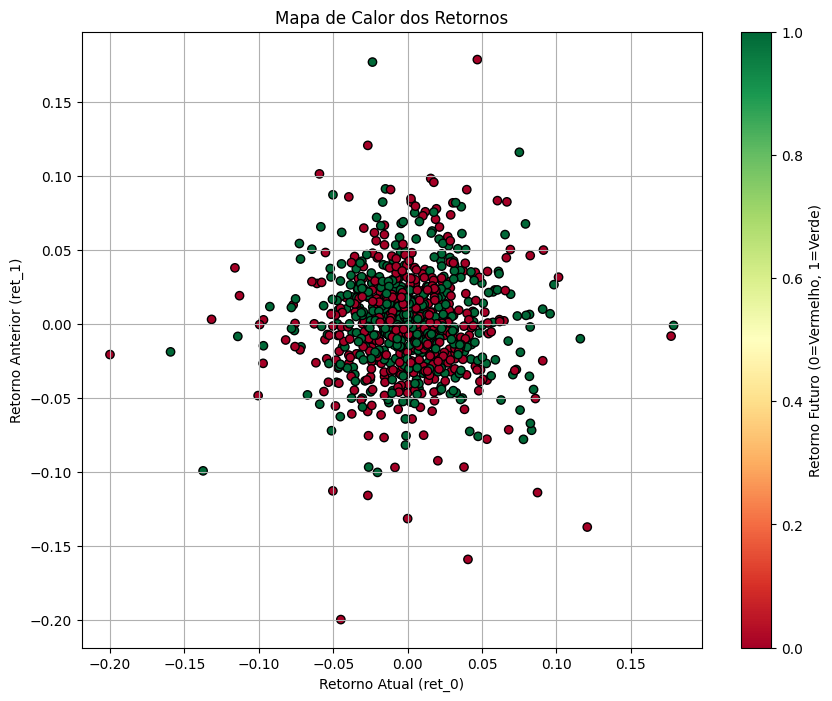

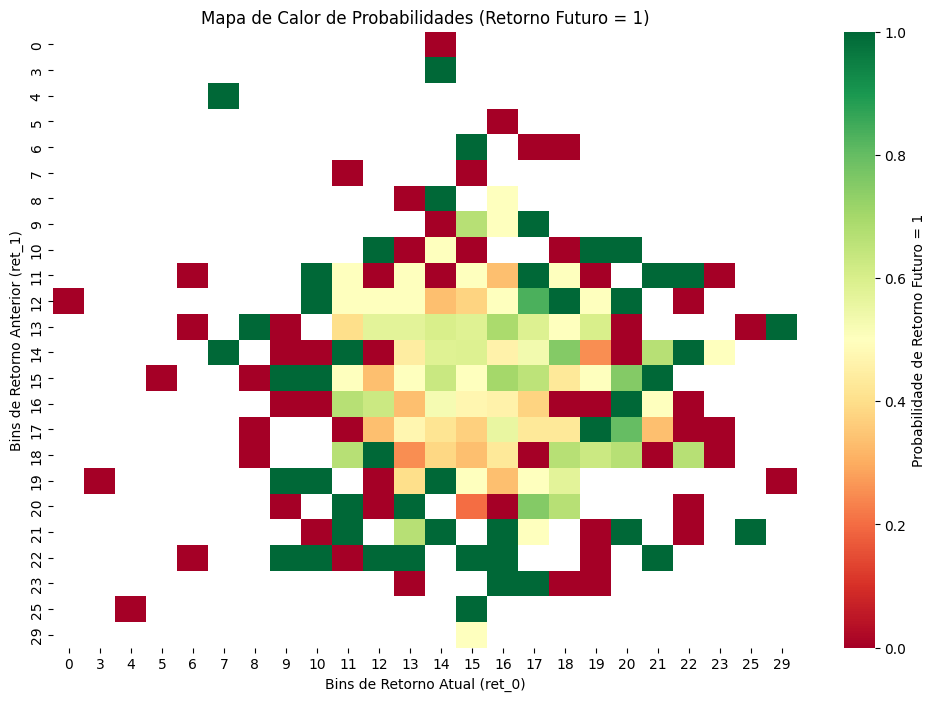

In [47]:
sim.df['ret_0'] = sim.df['Close'].pct_change()
sim.df['ret_1'] = sim.df['Close'].pct_change().shift(1)
sim.df['ret_futuro'] = np.where(sim.df['Close'].pct_change().shift(-1)>0,1,0)

# Removendo valores NaN gerados pelas transformações
sim.df = sim.df.dropna()

# Criando o mapa de calor
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    sim.df['ret_0'], 
    sim.df['ret_1'], 
    c=sim.df['ret_futuro'], 
    cmap='RdYlGn', 
    edgecolor='k', 
    alpha=1
)
plt.colorbar(sc, label='Retorno Futuro (0=Vermelho, 1=Verde)')
plt.title('Mapa de Calor dos Retornos')
plt.xlabel('Retorno Atual (ret_0)')
plt.ylabel('Retorno Anterior (ret_1)')
plt.grid(True)
plt.show()

import seaborn as sns

# Calculando a probabilidade de `ret_futuro` ser 1 para combinações de `ret_0` e `ret_1`
bins = 30  # Número de bins para discretização dos retornos
sim.df['ret_0_bin'] = pd.cut(sim.df['ret_0'], bins, labels=False)
sim.df['ret_1_bin'] = pd.cut(sim.df['ret_1'], bins, labels=False)

heatmap_data = sim.df.groupby(['ret_0_bin', 'ret_1_bin'])['ret_futuro'].mean().unstack()

# Plotando o mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    cmap="RdYlGn",
    annot=False,
    cbar_kws={'label': 'Probabilidade de Retorno Futuro = 1'}
)
plt.title('Mapa de Calor de Probabilidades (Retorno Futuro = 1)')
plt.xlabel('Bins de Retorno Atual (ret_0)')
plt.ylabel('Bins de Retorno Anterior (ret_1)')
plt.show()
